In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# hyper parameters
EPOCH = 2
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False

In [4]:
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),  # value : (0,1)
    download=DOWNLOAD_MNIST
)

Processing...
Done!


In [6]:
type(train_data)

torchvision.datasets.mnist.MNIST

torch.Size([60000, 28, 28])
torch.Size([60000])


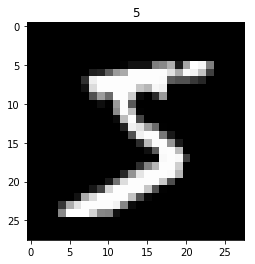

In [5]:
# plot one example
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])

In [7]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [10]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):                   # in forward, needs to consider batch_size dim.
        x = self.conv1(x)
        x = self.conv2(x)                   # -> (batch_size, 32, 7, 7)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

In [12]:
cnn = CNN()
print(cnn)

CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)


In [13]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()   # the target label is  not one-hotted

In [14]:
# training and testing
for epoch in range(EPOCH):
    for step, (x,y) in enumerate(train_loader):  # gives batch data, normalize x 
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y
        
        output = cnn(b_x)   # cnn output
        loss = loss_func(output, b_y)  # cross_entropy loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.4f' % accuracy)

Epoch:  0 | train loss: 2.3074 | test accuracy: 0.10
Epoch:  0 | train loss: 0.5347 | test accuracy: 0.74
Epoch:  0 | train loss: 0.2527 | test accuracy: 0.90
Epoch:  0 | train loss: 0.0915 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2256 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0629 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0994 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2149 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0766 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1013 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0502 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0622 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0926 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0114 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1805 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1873 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2410 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0459 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0664 | test accuracy

In [15]:
# print 10 predictions from test data
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [9]:
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=4)

In [ ]:
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1))